## Reading Data

In [6]:
# Library Imports.
import operator

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import KFold

from scipy.optimize import curve_fit

import sqlalchemy as sqla
import pymysql
from sqlalchemy import create_engine

import csv
import datetime as dt

In [7]:
URI='database-comp30830.c2kwpm1jk01q.us-east-1.rds.amazonaws.com'
PORT='3306'
DB='comp30830_db'
PASSWORD='Simple12'
USER='admin'

In [8]:
engine = create_engine("mysql+mysqldb://{}:{}@{}:{}/{}".format(USER, PASSWORD,
                                                              URI, PORT, DB), echo=True)

In [9]:
bikes=pd.read_sql_table('live_bike_data', engine)  

2020-03-28 11:58:40,810 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2020-03-28 11:58:40,812 INFO sqlalchemy.engine.base.Engine ()
2020-03-28 11:58:40,904 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2020-03-28 11:58:40,904 INFO sqlalchemy.engine.base.Engine ()
2020-03-28 11:58:41,088 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2020-03-28 11:58:41,089 INFO sqlalchemy.engine.base.Engine ()
2020-03-28 11:58:41,271 INFO sqlalchemy.engine.base.Engine show collation where `Charset` = 'utf8mb4' and `Collation` = 'utf8mb4_bin'
2020-03-28 11:58:41,274 INFO sqlalchemy.engine.base.Engine ()
2020-03-28 11:58:41,368 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2020-03-28 11:58:41,368 INFO sqlalchemy.engine.base.Engine ()
2020-03-28 11:58:41,460 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2020-03-28 11:58:41,460 INFO sqlalchemy.engine.base.E

In [10]:
# Make a new dataframe of this table
bikes.to_csv('allBikes.csv', index=False)

In [11]:
# Read csv file into a dataframe.
bikes = pd.read_csv('allBikes.csv')

In [12]:
weather=pd.read_sql_table('live_weather_data', engine)  

2020-03-28 11:59:11,746 INFO sqlalchemy.engine.base.Engine SHOW FULL TABLES FROM `comp30830_db`
2020-03-28 11:59:11,747 INFO sqlalchemy.engine.base.Engine ()
2020-03-28 11:59:11,839 INFO sqlalchemy.engine.base.Engine SHOW FULL TABLES FROM `comp30830_db`
2020-03-28 11:59:11,839 INFO sqlalchemy.engine.base.Engine ()
2020-03-28 11:59:11,930 INFO sqlalchemy.engine.base.Engine SHOW CREATE TABLE `live_weather_data`
2020-03-28 11:59:11,931 INFO sqlalchemy.engine.base.Engine ()
2020-03-28 11:59:12,120 INFO sqlalchemy.engine.base.Engine SELECT live_weather_data.number, live_weather_data.main, live_weather_data.description, live_weather_data.icon, live_weather_data.temp, live_weather_data.`tempMin`, live_weather_data.`tempMax`, live_weather_data.`tempFeels`, live_weather_data.humidity, live_weather_data.pressure, live_weather_data.`windSpeed`, live_weather_data.`windDeg`, live_weather_data.rain, live_weather_data.sunrise, live_weather_data.sunset, live_weather_data.date, live_weather_data.time, 

In [13]:
# Make a new dataframe of this table
weather.to_csv('allWeather.csv', index=False)

In [14]:
# Read csv file into a dataframe.
weather = pd.read_csv('allWeather.csv')

In [15]:
bikes['datetime'] = pd.to_datetime(bikes['date'] + ' ' + bikes['time'])
weather['datetime'] = pd.to_datetime(weather['date'] + ' ' + weather['time'])

In [16]:
bikes = bikes.sort_values(by='datetime')
weather = weather.sort_values(by='datetime')

## This can be used as a checkpoint, start from here if you want to run again without having to call from the database.

In [17]:
full_df = pd.merge_asof(bikes, weather, left_on="datetime", right_on="datetime",direction="nearest")

In [18]:
full_df.head(3)

,ID,availableBikeStands,availableBikes,date_x,time_x,day_x,status,epoch,datetime,number,...,humidity,pressure,windSpeed,windDeg,rain,sunrise,sunset,date_y,time_y,day_y
0,84,6,24,2020-02-18,19:54:59,Tue,OPEN,NaN,2020-02-18 19:54:59,802,...,72.0,1015.0,5.7,250.0,0.0,07:38:33,17:39:42,2020-02-18,22:00:01,Tue
1,67,21,19,2020-02-18,19:55:27,Tue,OPEN,NaN,2020-02-18 19:55:27,802,...,72.0,1015.0,5.7,250.0,0.0,07:38:33,17:39:42,2020-02-18,22:00:01,Tue
2,8,30,0,2020-02-18,19:55:35,Tue,OPEN,NaN,2020-02-18 19:55:35,802,...,72.0,1015.0,5.7,250.0,0.0,07:38:33,17:39:42,2020-02-18,22:00:01,Tue


In [19]:
# constrict the dataframe to only those times in which the service is available to users.
full_df = full_df.drop(full_df[(full_df.datetime.dt.hour > 0) & (full_df.datetime.dt.hour < 5)].index)

In [20]:
## Create four each flags representing the stage of the day.
morning_start = pd.to_datetime("05:00:00").time()
morning_end = pd.to_datetime("12:00:00").time()
afternoon_start = pd.to_datetime("12:01:00").time()
afternoon_end = pd.to_datetime("16:59:00").time()
evening_start = pd.to_datetime("17:00:00").time()
evening_end = pd.to_datetime("20:00:00").time()
night_start = pd.to_datetime("20:01:00").time()
night_end = pd.to_datetime("23:59:59").time()

In [21]:
full_df['morning'] = np.where((full_df['datetime'].dt.time > morning_start)
                         & (full_df['datetime'].dt.time < morning_end),
                         1, 0)

full_df['afternoon'] = np.where((full_df['datetime'].dt.time > afternoon_start)
                         & (full_df['datetime'].dt.time < afternoon_end),
                         1, 0)

full_df['evening'] = np.where((full_df['datetime'].dt.time > evening_start)
                         & (full_df['datetime'].dt.time < evening_end),
                         1, 0)

full_df['night'] = np.where((full_df['datetime'].dt.time > night_start)
                         & (full_df['datetime'].dt.time < night_end),
                         1, 0)

In [22]:
#replace days with numbers
full_df["day_x"].replace(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], [0,1,2,3,4,5,6], inplace=True)

In [23]:
# create a time of day column, based on the hours of the day.
full_df['tod'] = full_df.datetime.dt.hour

- Observe the usage on a given weekday at a particular station:

In [24]:
weekday_test_df = full_df.loc[(full_df['ID'] == 84) & (full_df['day_x'] == 2)]

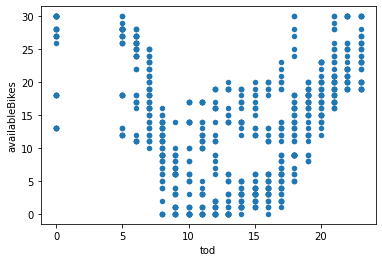

In [25]:
# First, plot the observed data
weekday_test_df.plot(kind='scatter', x='tod', y='availableBikes')

In [26]:
weekday_test_df = full_df.loc[(full_df['ID'] == 84) & (full_df['day_x'] == 4)]

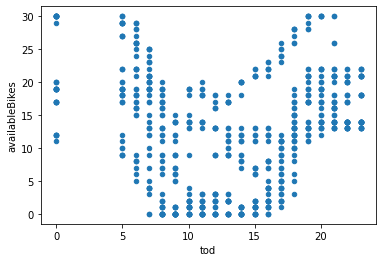

In [27]:
weekday_test_df.plot(kind='scatter', x='tod', y='availableBikes')

- Observe the usage on a given weekend day at the same station:

In [28]:
weekend_test_df = full_df.loc[(full_df['ID'] == 84) & (full_df['day_x'] == 5)]

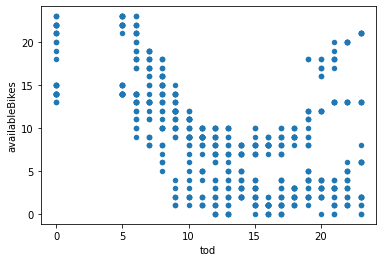

In [29]:
# First, plot the observed data
weekend_test_df.plot(kind='scatter', x='tod', y='availableBikes')

### We can see two varying patterns for days of the week compared to days of the weekend; therefore two spearate models will be developed- one for Monday to Friday and another for Saturdays and Sundays.

In [30]:
#clouds
full_df["number"].replace([801,802,803,804], 'clouds', inplace=True)

#clear
full_df["number"].replace([800], 'clear', inplace=True)

#Atmosphere
full_df["number"].replace([701,711,721,731,741,751,761,762,771,781], 'Atmosphere', inplace=True)

#snow
full_df["number"].replace([600,601,602,611,612,613,615,616,620,621,622], 'snow', inplace=True)

#rain
full_df["number"].replace([500,501,502,503,504,511,520,521,522,531], 'rainfall', inplace=True)

#drizzle
full_df["number"].replace([300,301,302,310,311,312,313,314,321], 'drizzle', inplace=True)

#thunderstorm
full_df["number"].replace([200,201,202,210,211,212,221,230,231,232], 'thunderstorm', inplace=True)

In [31]:
full_df.head()

,ID,availableBikeStands,availableBikes,date_x,time_x,day_x,status,epoch,datetime,number,...,sunrise,sunset,date_y,time_y,day_y,morning,afternoon,evening,night,tod
0,84,6,24,2020-02-18,19:54:59,1,OPEN,NaN,2020-02-18 19:54:59,clouds,...,07:38:33,17:39:42,2020-02-18,22:00:01,Tue,0,0,1,0,19
1,67,21,19,2020-02-18,19:55:27,1,OPEN,NaN,2020-02-18 19:55:27,clouds,...,07:38:33,17:39:42,2020-02-18,22:00:01,Tue,0,0,1,0,19
2,8,30,0,2020-02-18,19:55:35,1,OPEN,NaN,2020-02-18 19:55:35,clouds,...,07:38:33,17:39:42,2020-02-18,22:00:01,Tue,0,0,1,0,19
3,106,20,20,2020-02-18,19:55:57,1,OPEN,NaN,2020-02-18 19:55:57,clouds,...,07:38:33,17:39:42,2020-02-18,22:00:01,Tue,0,0,1,0,19
4,36,38,0,2020-02-18,19:56:09,1,OPEN,NaN,2020-02-18 19:56:09,clouds,...,07:38:33,17:39:42,2020-02-18,22:00:01,Tue,0,0,1,0,19


In [32]:
full_df.drop(["date_x","time_x","status", "epoch", "main",
         "description","icon", "tempMin", "tempMax", "tempFeels", "humidity",
         "pressure", "windSpeed","windDeg","sunrise", "sunset",
             "date_y","time_y", "day_y"],axis=1,inplace=True)

In [33]:
# add a flag that indicates whether a day is dry (has zero rain)
full_df['dry_day'] = (full_df['rain'] == 0).astype(int)

In [34]:
choice = int(input("Please enter a number to predict for either availableBikes - (0) or availableBikeStands - (1): "))
if choice == 0:
    full_df = full_df.rename(columns={"availableBikes": "target"})
    full_df.drop(["availableBikeStands"], axis=1,inplace=True)    
else:
    full_df = full_df.rename(columns={"availableBikeStands": "target"})
    full_df.drop(["availableBikes"], axis=1,inplace=True)

Please enter a number to predict for either availableBikes - (0) or availableBikeStands - (1): 0


In [35]:
week_df = full_df.loc[(full_df['day_x'] >= 0) & (full_df['day_x'] <= 4)]

In [36]:
weekend_df = full_df.loc[(full_df['day_x'] >= 5) & (full_df['day_x'] <= 6)]

In [37]:
station = int(input("Please enter station ID: "))
week_or_weekend = int(input("Please choose to predict for week - (0) or weekend - (1): "))
# bikes_or_stands = int(input("Please choose to predict either availableBikeStands(0) or availableBikes(1): "))
# Constrain df to a single station on a single day
if week_or_weekend == 0:
    new_df = week_df.loc[(week_df.ID == station)]
else:
    new_df = weekend_df.loc[(weekend_df.ID == station)]

# Constrain df to a single station on a single day
# new_df = full_df.loc[(full_df['ID'] == station) & (full_df['day_x'] == day)]

Please enter station ID: 13
Please choose to predict for week - (0) or weekend - (1): 0


In [38]:
## Dropping all columns not necessary for predictive model.
new_df.drop(["ID", "datetime"], axis=1,inplace=True)

C:\Users\mrric\Anaconda3\envs\comp30830\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [39]:
# Make a new dataframe of this station
new_df.to_csv('comp303830_model_multipleLinearRegression.csv', index=False)

In [40]:
# Read csv file into a dataframe.
df = pd.read_csv('comp303830_model_multipleLinearRegression.csv')

In [41]:
df.head(3)

,target,day_x,number,temp,rain,morning,afternoon,evening,night,tod,dry_day
0,0,1,clouds,2.0,0.0,0,0,1,0,19,1
1,0,1,clouds,2.0,0.0,0,0,0,1,20,1
2,0,1,clouds,2.0,0.0,0,0,0,1,20,1


In [42]:
# Print the average target(availableBikes/availableBikeStands) in our dataset.
# We could use this as a very simple baseline prediction model.
# A better prediction model should at least improve on this baseline model.
round(df.target.mean())

10.0

### Observing the data:
- Trying to find correlations between continuous data and the target feature:

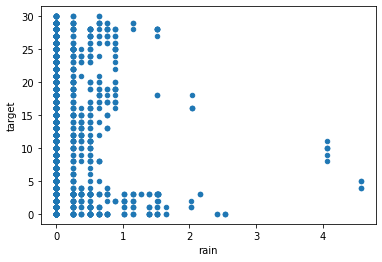

In [43]:
# First, plot the observed data
df.plot(kind='scatter', x='rain', y='target')

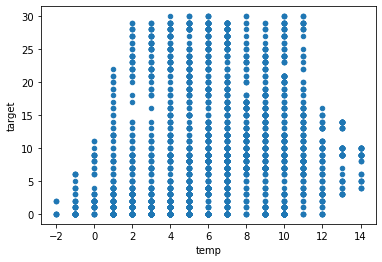

In [44]:
# First, plot the observed data
df.plot(kind='scatter', x='temp', y='target')

- There does not appear to be a clear correlation between the target feature and the continuous data

In [45]:
## Keep these lists for later.
## Will be used below.
x_list = df.tod.tolist()
y_list = df.target.tolist()

In [46]:
## Keep this pandas series for later.
## Will be used below.
tod_placeholder = df[['tod']]

# Training with continuous and categorical features

In [47]:
#replace days with numbers
df["day_x"].replace([0,1,2,3,4,5,6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], inplace=True)

In [48]:
#We can also do this directly for all categorical features
df = pd.get_dummies(df, drop_first=True)

In [49]:
# Input features must exclude the target feature
column_names = list(df.columns)[1:]

In [50]:
X = df[column_names]
y = df.target

In [51]:
# drop_first = True removes multi-collinearity
add_var = pd.get_dummies(X['tod'], prefix='tod', drop_first=True)
# Add all the columns to the model data
X = X.join(add_var)
# Drop the original column that was expanded
X.drop(columns=['tod'], inplace=True)

In [52]:
X.head()

,temp,rain,morning,afternoon,evening,night,dry_day,day_x_Mon,day_x_Thu,day_x_Tue,...,tod_14,tod_15,tod_16,tod_17,tod_18,tod_19,tod_20,tod_21,tod_22,tod_23
0,2.0,0.0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,2.0,0.0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,2.0,0.0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,2.0,0.0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,2.0,0.0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [53]:
# Drop any rows with null values
df.dropna(axis=0, how='any', inplace=True)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
df['predicted'] = model.predict(X)

In [54]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

In [55]:
printMetrics(y, model.predict(X))


MAE:  4.432976117077636
RMSE:  5.376704667149429
R2:  0.620305402830249


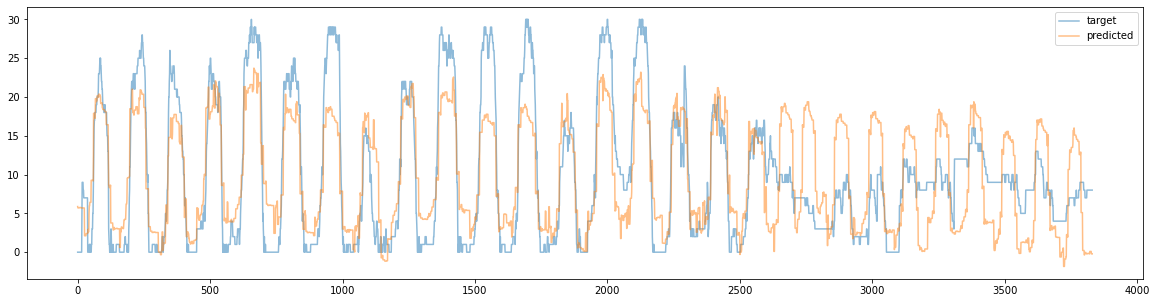

In [56]:
df[['target', 'predicted']].plot(alpha=0.5, figsize=(20, 5))

<ref: https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html >

In [57]:
df.head()

,target,temp,rain,morning,afternoon,evening,night,tod,dry_day,day_x_Mon,day_x_Thu,day_x_Tue,day_x_Wed,number_clear,number_clouds,number_drizzle,number_rainfall,predicted
0,0,2.0,0.0,0,0,1,0,19,1,0,0,1,0,0,1,0,0,5.878382
1,0,2.0,0.0,0,0,0,1,20,1,0,0,1,0,0,1,0,0,5.705237
2,0,2.0,0.0,0,0,0,1,20,1,0,0,1,0,0,1,0,0,5.705237
3,0,2.0,0.0,0,0,0,1,20,1,0,0,1,0,0,1,0,0,5.705237
4,0,2.0,0.0,0,0,0,1,20,1,0,0,1,0,0,1,0,0,5.705237


## Document here on the errors between the predicted and actual values. The model, while not perfect, will suffice for the time being anyway.

In [58]:
params = pd.Series(model.coef_, index=X.columns)
params

temp               -0.316135
rain               -0.631697
morning             6.927658
afternoon           3.372730
evening             2.179554
night               0.585211
dry_day            -0.777161
day_x_Mon           3.181740
day_x_Thu           1.804614
day_x_Tue           4.335050
day_x_Wed           1.466118
number_clear        3.457427
number_clouds       2.057744
number_drizzle      5.545833
number_rainfall     4.446798
tod_5              -6.320116
tod_6              -5.775118
tod_7              -4.825815
tod_8              -1.988358
tod_9               6.721698
tod_10              9.243698
tod_11              9.871669
tod_12             13.868634
tod_13             12.957703
tod_14             12.714015
tod_15             12.467261
tod_16             10.765902
tod_17              4.172411
tod_18             -0.708323
tod_19             -1.284535
tod_20              0.136663
tod_21              0.192025
tod_22              0.128988
tod_23              0.127535
dtype: float64

In [59]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [60]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

                 effect  error
temp               -0.0    0.0
rain               -1.0    0.0
morning             7.0    0.0
afternoon           3.0    1.0
evening             2.0    0.0
night               1.0    0.0
dry_day            -1.0    0.0
day_x_Mon           3.0    0.0
day_x_Thu           2.0    0.0
day_x_Tue           4.0    0.0
day_x_Wed           1.0    0.0
number_clear        3.0    1.0
number_clouds       2.0    0.0
number_drizzle      6.0    1.0
number_rainfall     4.0    0.0
tod_5              -6.0    0.0
tod_6              -6.0    0.0
tod_7              -5.0    0.0
tod_8              -2.0    0.0
tod_9               7.0    0.0
tod_10              9.0    0.0
tod_11             10.0    0.0
tod_12             14.0    1.0
tod_13             13.0    1.0
tod_14             13.0    1.0
tod_15             12.0    1.0
tod_16             11.0    1.0
tod_17              4.0    0.0
tod_18             -1.0    0.0
tod_19             -1.0    0.0
tod_20              0.0    0.0
tod_21  

<ref: https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5 >

##  Linear regression with nonlinear data: sidebar - we will not actually be using this model due to time constraints faced with implementing it.

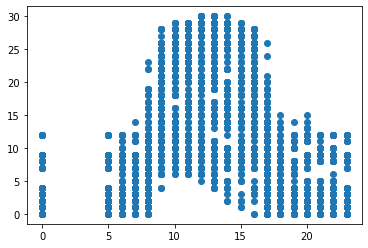

In [61]:
x = np.asarray(x_list)
y_new = np.asarray(y_list)
plt.scatter(x, y_new);

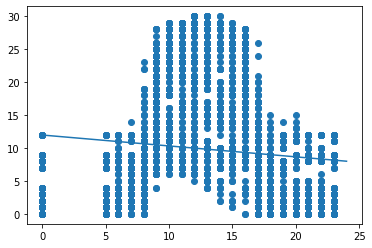

In [62]:
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y_new)

xfit = np.linspace(0, 24, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y_new)
plt.plot(xfit, yfit);

In [63]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     -0.165660447575731
Model intercept: 11.974519191748872


In [64]:
# transforming the data to include another axis
x = x[:, np.newaxis]
y_new = y_new[:, np.newaxis]

In [65]:
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y_new)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y_new,y_poly_pred))
r2 = r2_score(y_new,y_poly_pred)
print("Root Mean Square Error: ", rmse)
print("Coefficient of Determination (R2): ", r2)

Root Mean Square Error:  7.24132027866874
Coefficient of Determination (R2):  0.31128813320612236


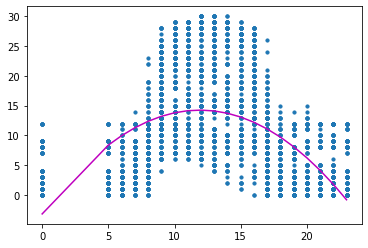

In [66]:
plt.scatter(x, y_new, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

# Explore this one more time before submitting.

<ref: https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html >

# Evaluation with train/test split

In [67]:
# Split the data into train and test sets
# Take a third (random) data samples as test data, rest as training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# If we want to get the same train/test split every time we run, we can set the random_state variable to a fixed value
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# print("Training data:\n", pd.concat([X_train, y_train], axis=1))
# print("\nTest data:\n", pd.concat([X_test, y_test], axis=1))

In [68]:
features = list(df.columns)[1:]

In [69]:
# Train on the training sample and test on the test sample.
linreg = LinearRegression().fit(X_train, y_train)
# Print the weights learned for each feature.
#print(linreg_train.coef_)
print("Features and coeficients:", list(zip(features, linreg.coef_)))

Features and coeficients: [('temp', -0.3135515872779868), ('rain', -0.8378523997516656), ('morning', 6.107036844303681), ('afternoon', 3.9001885988681084), ('evening', 1.6155941354047978), ('night', 0.01230018432703775), ('tod', -1.5382932760716819), ('dry_day', 3.3205092151151554), ('day_x_Mon', 1.6869834080655874), ('day_x_Thu', 4.440770738757687), ('day_x_Tue', 1.2895869379771676), ('day_x_Wed', 2.0631984849400884), ('number_clear', 0.6145140758858872), ('number_clouds', 3.573975067247713), ('number_drizzle', 2.499270972668275), ('number_rainfall', -6.517606877830661), ('predicted', -5.536207968886492)]


In [70]:
# Predicted bikes on training set
train_predictions = linreg.predict(X_train)
# print("Actual values of training:\n", y_train)
# print("Predictions on training:", train_predictions)
printMetrics(y_train, train_predictions)


MAE:  4.460669899074248
RMSE:  5.401942612155674
R2:  0.6172331680480241


In [71]:
# Predicted bikes on test set
test_predictions = linreg.predict(X_test)
# print("Actual values of test:\n", y_test)
# print("Predictions on test:", test_predictions)
printMetrics(y_test, test_predictions)


MAE:  4.34604949508095
RMSE:  5.311377868546095
R2:  0.6283181412592873


# Evaluation with cross-validation

In [72]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [73]:
scores = -cross_val_score(LinearRegression(), X, y, scoring='neg_mean_absolute_error', cv=5)
scores

array([4.36276399, 4.90247381, 5.76332289, 5.42752222, 6.48920846])

In [74]:
metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
scores = cross_validate(LinearRegression(), X, y, scoring=metrics, cv=5)
scores

{'fit_time': array([0.00398898, 0.00398898, 0.00498724, 0.004987  , 0.00299335]),
 'score_time': array([0.00099778, 0.00199485, 0.00199389, 0.00099683, 0.00099826]),
 'test_neg_mean_absolute_error': array([-4.36276399, -4.90247381, -5.76332289, -5.42752222, -6.48920846]),
 'test_neg_mean_squared_error': array([-25.36503086, -36.39035799, -48.56689807, -51.0602848 ,
        -49.23846336]),
 'test_r2': array([ 0.76045165,  0.66762505,  0.57100091, -1.08221969, -3.79051424])}

In [75]:
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_neg_mean_absolute_error',
 'test_neg_mean_squared_error',
 'test_r2']

# Training with continuous and categorical features

<ref: https://stackoverflow.com/questions/34007308/linear-regression-analysis-with-string-categorical-features-variables >

<ref: https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9 >